# Code setup for Experiments

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
import multiprocessing

from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.inference import * 
from bayes_opt import BayesianOptimization
from lib.parallel import *
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval)

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

In [2]:
mob_settings = 'lib/tu_settings_20_10.pk'
random_repeats = 20 # Set to at least 20 for stable results
cpus_used = multiprocessing.cpu_count() 
c = 0 # seed
FIGSIZE = (8, 4)

#### Import town settings

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

In [3]:
# See town-generator.ipynb for an example on how to create own settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)
np.random.seed(c)
runstr = f'run{c}_'

# General note for plotting: `errorevery` has to be set proportionally to `acc`, and best to keep `acc` as it is

### Import COVID-19 data

In [4]:
days_until_lockdown = 13 # March 10 - March 23
days_after_lockdown = 20 # March 24 - April 12
days_present = days_until_lockdown + days_after_lockdown + 2 # simulate 2 more days due to test lag

In [5]:
case_downsample = 10
new_cases_ = collect_data_from_df('LK Tübingen', 'new', until=days_present)
resistant_cases_ = collect_data_from_df('LK Tübingen', 'recovered', until=days_present)
fatality_cases_ = collect_data_from_df('LK Tübingen', 'fatality', until=days_present)

Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr


In [6]:
# fatality rate per age group
num_age_groups = fatality_cases_.shape[1] 
fatality_rates_by_age = (fatality_cases_[-1, :] / \
    (new_cases_[-1, :] + fatality_cases_[-1, :] + resistant_cases_[-1, :]))

print('Empirical fatality rates per age group:  ', fatality_rates_by_age.tolist())

Empirical fatality rates per age group:   [0.0, 0.0, 0.0, 0.001430615164520744, 0.00964630225080386, 0.11728395061728394]


Scale down cases based on number of people in simulation

In [7]:
new_cases, resistant_cases, fatality_cases = (
    1/case_downsample * new_cases_, 
    1/case_downsample * resistant_cases_, 
    1/case_downsample * fatality_cases_)
new_cases, resistant_cases, fatality_cases = np.ceil(new_cases), np.ceil(resistant_cases), np.ceil(fatality_cases)

Define initial seed count (based on infection counts on March 10)

In [8]:
initial_seeds = {
    'expo' : 1,
    'ipre' : 1,
    'isym' : 3,
    'iasy' : 3,
}
max_time_present = 24.0 * (days_present)

#### Define standard testing parameters, same used for inference

In [9]:
def standard_testing(max_time):
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 24.0,     # in hours
        'test_reporting_lag'  : 48.0,     # in hours (actual and self-report delay)
        'tests_per_batch'     : 10,       # assume 300 tests/day in LK Tübingen
        'test_smart_delta'    : 24.0 * 3, # in hours
        'test_smart_duration' : 24.0 * 7, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

#### Define distributions as estimated by literature 


In [10]:
# instantiate correct distributions
distributions = CovidDistributions(fatality_rates_by_age=fatality_rates_by_age)

#### Set epidemic parameters as inferred using Bayesian optimization

In [11]:
inferred_params = {
    'betas': [1.1383] * 5,  # site infectivity by type
    'alpha': 0.3224,
    'mu': 0.2072
}

Define function to run general type of experiment, fixing the above settings.


In [12]:
def run(tparam, measure_list, t, local_seeds):

    # add standard measure of positives staying isolated
    measure_list +=  [
        SocialDistancingForPositiveMeasure(
            t_window=Interval(0.0, t), p_stay_home=1.0)
    ]
    measure_list = MeasureList(measure_list)

    # run simulations
    summary = launch_parallel_simulations(
        mob_settings, 
        distributions, 
        random_repeats, multiprocessing.cpu_count(), 
        inferred_params, local_seeds, tparam, measure_list, 
        max_time=t, 
        num_people=mob.num_people, 
        num_sites=mob.num_sites, 
        site_loc=mob.site_loc, 
        home_loc=mob.home_loc, verbose=False)
    return summary
    

In [13]:
def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

# Experiments for "A spatiotemporal model for Sars-CoV-2"

## 4.3. Social distancing and Business restrictions

### 4.3.1. Reproducing the observed course of Sars-CoV-2 under the taken interventions

In [21]:
# {0: 'education', 1: 'social', 2: 'bus_stop', 3: 'office', 4: 'supermarket'}
tuned_p_stay_home = 0.3 # FIXME
tuned_site_multipliers = [0.0, 0.0, 0.5, 0.5, 0.5]

observed_measures_SD = [
    # education close, social closes, rest reduced by 50%
    BetaMultiplierMeasureByType(
        t_window=Interval(24.0 * days_until_lockdown, max_time_present), 
        beta_multiplier=tuned_site_multipliers),
    
    # 40 % less activite of all due to contact constraints
    SocialDistancingForAllMeasure(
     t_window=Interval(24.0 * days_until_lockdown, max_time_present), 
        p_stay_home=tuned_p_stay_home)
]

In [22]:
testing_params_SD_0 = standard_testing(max_time_present)
summary_SD_0 = run(testing_params_SD_0, observed_measures_SD, max_time_present, initial_seeds)

save_summary(summary_SD_0, 'summary_SD_0.pk')

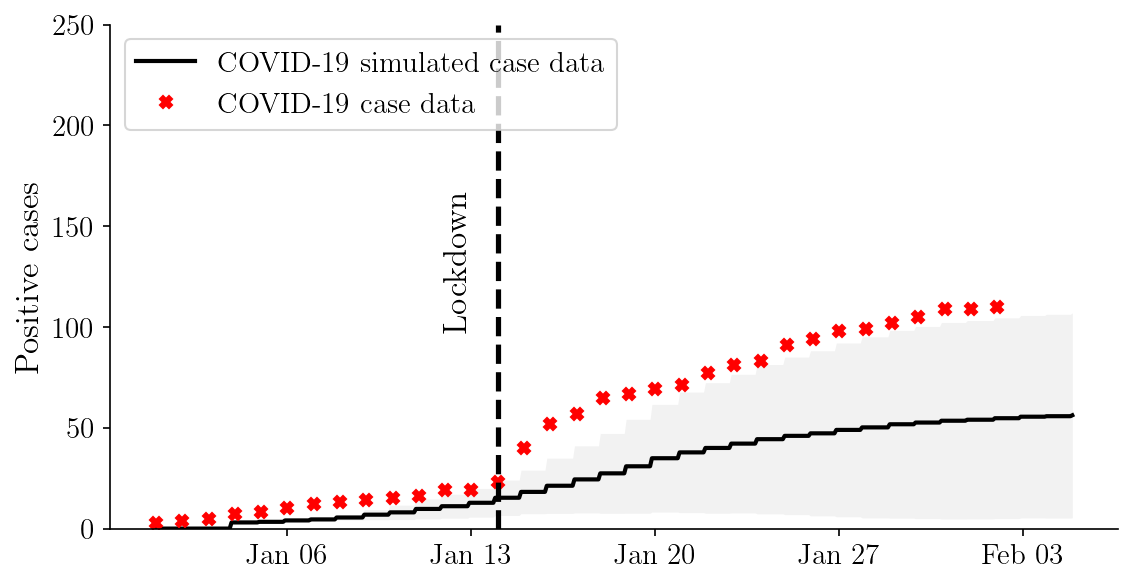

In [23]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_SD_0, new_cases.sum(axis=1), 
    test_lag=2,
    title='Predictions for observed controlled scenario after March 23', 
    filename=runstr + 'SD_000',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=250)



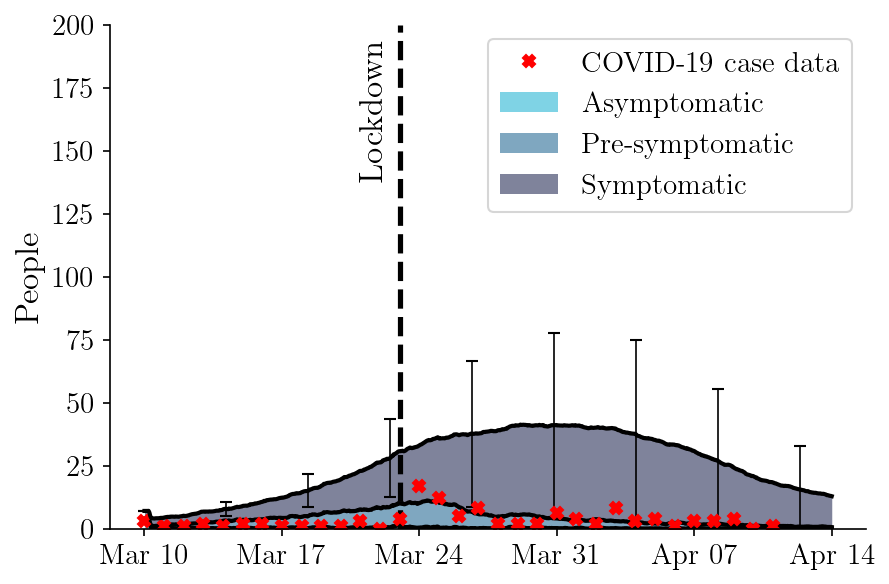

In [24]:
targets = new_cases.sum(axis=1)
targets = np.hstack((targets[0], np.diff(targets)))

plotter = Plotter()
plotter.plot_daily_infected(
    summary_SD_0,
    title='', 
    filename=runstr + 'SD_001',
    errorevery=100, acc=1000, 
    figsize=(6, 4),
    start_date='2020-03-10',
    show_target=targets,
    lockdown_at=days_until_lockdown,
    lockdown_label_y=140,
    lockdown_label='Lockdown',
    ymax=200)

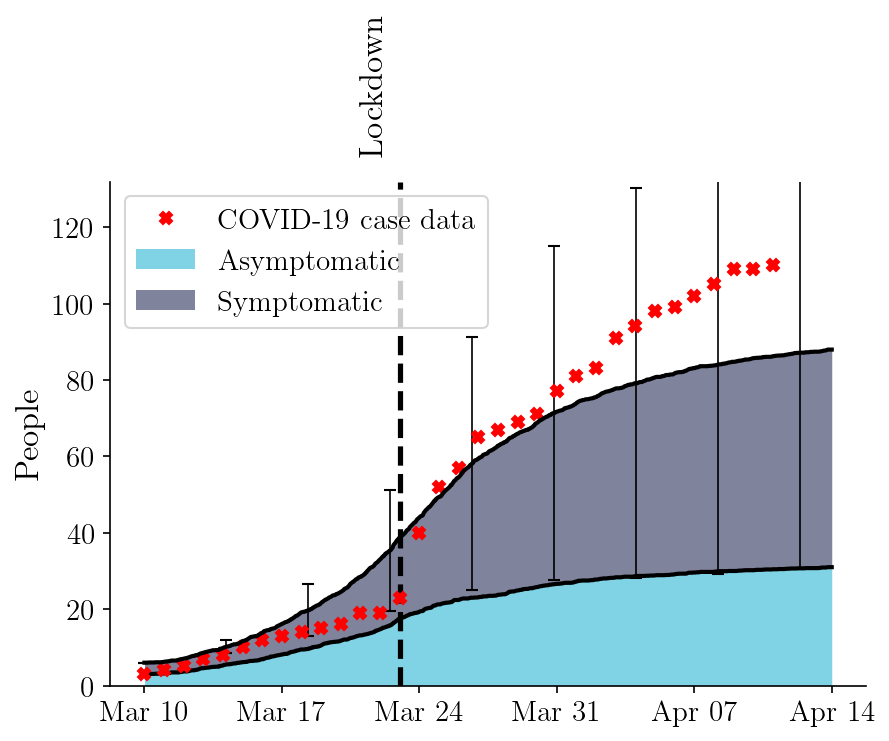

In [25]:
plotter = Plotter()
plotter.plot_cumulative_infected(
    summary_SD_0,
    title='', 
    filename=runstr + 'SD_002',
    figsize=(6, 4),
    legend_loc='upper left',
    errorevery=100, acc=1000, 
    start_date='2020-03-10',
    lockdown_at=days_until_lockdown,
    lockdown_label_y=140,
    show_target=new_cases.sum(axis=1),
    ymax=None)

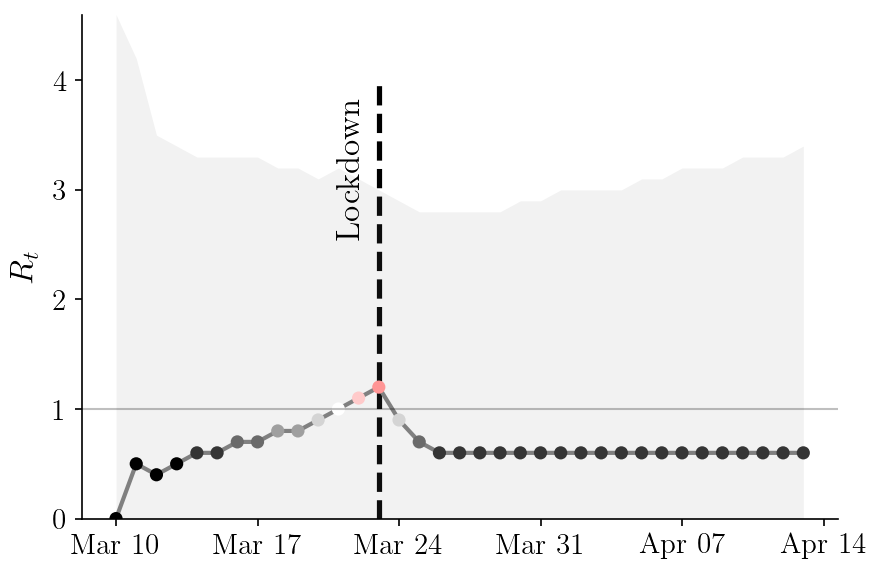

In [26]:
plotter = Plotter()
plotter.plot_daily_rts(
    summary_SD_0,
    filename=runstr + 'SD_003',
    start_date='2020-03-10',
    sigma=0.37, 
    figsize=(6, 4), 
    subplot_adjust=None,
    lockdown_label='Lockdown', 
    lockdown_at=days_until_lockdown,
    lockdown_label_y=2.6,
    ymax=4.0)

In [27]:
plt.close()